# LightGBM Tuning

### Setup

In [1]:
from src.load_data import *
from src.realtime_utils import *
from src.hp_tuning_functions import *

In [2]:
from darts.models.forecasting.lgbm import LightGBMModel

/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/statsforecast/utils.py:231: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  "ds": pd.date_range(start="1949-01-01", periods=len(AirPassengers), freq="M"),


### Configuration

In [3]:
NAME = 'lightgbm'

NUM_SAMPLES = 1000
HORIZON = 4

ENCODERS = {
    'datetime_attribute': {'future': ['month', 'weekofyear']}
}

SHARED_ARGS = dict(
    output_chunk_length=HORIZON,
)

lags_covariates = {
    'agi-are-DE': 8,
    'agi-are-00-04': 8,
    'agi-are-05-14': 8,
    'agi-are-15-34': 8,
    'agi-are-35-59': 8,
    'agi-are-60+': 8,
    'default_lags': 1
}

sweep_configuration = {
    "name": f"sari-{NAME}",
    "method": "grid",
    "metric": {"goal": "minimize", "name": "WIS"},  
    "parameters": {
        #"model": {"values": [NAME]},  
        #"multiple_series": {"values": [False]},
        "use_covariates" :  {"values" : [True, False]},
        #"use_features" :  {"values" : [False]},
        "use_encoders" :  {"values" : [True]},
        "use_static_covariates" :  {"values" : [False]},
        "sample_weight" : {"values" : ["linear", "no-covid"]},
        "lags": {"values": [8]},
        "lags_past_covariates": {"values": [lags_covariates]},
        "lags_future_covariates": {"values": [(0, 1)]},
        "num_leaves": {"values": [20, 31, 63]},  # Number of leaves
        "max_depth": {"values": [-1]},  # Max depth of trees
        "learning_rate": {"values": [0.01, 0.05, 0.1]},  # Learning rate
        "n_estimators": {"values": [500, 1000]},  # Number of boosting rounds
        "min_child_samples": {"values": [5, 10, 20]},  # Minimum child samples per leaf
        "subsample": {"values": [0.8]},  # Subsampling ratio
        "colsample_bytree": {"values": [0.8]},  # Feature fraction for building trees
        "reg_alpha": {"values": [0, 0.5, 1.0]},  # L1 regularization
        "reg_lambda": {"values": [0, 0.5, 1.0]},  # L2 regularization
        "subsample_freq": {"values": [1]},  # Subsampling frequency
        "min_split_gain": {"values": [0.0]},  # Minimum gain to split
        "max_bin": {"values": [1024]},  # Maximum number of bins
    }
}

In [4]:
3**5*16

3888

### Load data

In [5]:
targets, covariates = load_realtime_training_data()

In [6]:
targets_train, targets_validation = train_validation_split(targets, 2022)

<Axes: xlabel='date'>

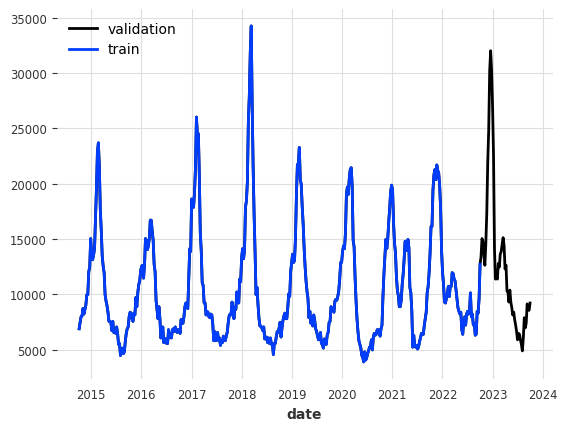

In [7]:
targets_validation['icosari-sari-DE'].plot(label='validation')
targets_train['icosari-sari-DE'].plot(label='train')

In [8]:
VALIDATION_YEARS = [2022]

In [9]:
RANDOM_SEEDS = [1]

In [10]:
custom_weights = exclude_covid_weights(targets)

In [11]:
import numpy as np
import pandas as pd
from itertools import product

In [12]:
def space_from_sweep(sweep_cfg: dict) -> dict:
    return {k: list(v["values"]) for k, v in sweep_cfg["parameters"].items()}

def iter_configs(space: dict):
    keys = list(space.keys())
    for vals in product(*(space[k] for k in keys)):
        yield dict(zip(keys, vals))

In [16]:
def eval_config(cfg: dict) -> dict:
    lags_past   = cfg["lags_past_covariates"] if cfg["use_covariates"] else None
    lags_future = cfg["lags_future_covariates"] if cfg["use_encoders"]   else None

    all_scores = []
    per_year = {}

    for year in VALIDATION_YEARS:
        targets_train, targets_val = train_validation_split(targets, year)
        year_scores = []

        for seed in RANDOM_SEEDS:
            model = LightGBMModel(
                lags=cfg["lags"],
                lags_past_covariates=lags_past,
                lags_future_covariates=lags_future,
                num_leaves=cfg["num_leaves"],
                max_depth=cfg["max_depth"],
                learning_rate=cfg["learning_rate"],
                n_estimators=cfg["n_estimators"],
                min_child_samples=cfg["min_child_samples"],
                subsample=cfg["subsample"],
                colsample_bytree=cfg["colsample_bytree"],
                reg_alpha=cfg["reg_alpha"],
                reg_lambda=cfg["reg_lambda"],
                subsample_freq=cfg["subsample_freq"],
                min_split_gain=cfg["min_split_gain"],
                max_bin=cfg["max_bin"],
                use_static_covariates=cfg["use_static_covariates"],
                add_encoders=ENCODERS if cfg["use_encoders"] else None,
                verbose=-1,
                likelihood="quantile",
                quantiles=QUANTILES,
                **SHARED_ARGS,
                random_state=seed
            )

            weight = custom_weights if cfg["sample_weight"] == "no-covid" else cfg["sample_weight"]
            score = compute_validation_score(
                model, targets_train, targets_val,
                covariates if cfg["use_covariates"] else None,
                HORIZON, NUM_SAMPLES, METRIC, METRIC_KWARGS,
                sample_weight=weight,
            )
            print(score)
            year_scores.append(score)
            all_scores.append(score)

        per_year[f"WIS_{year}"] = np.mean(year_scores)

    return {
        "WIS": np.mean(all_scores),
        **{f"cfg.{k}": v for k, v in cfg.items()},
        **per_year,
    }

In [14]:
space = space_from_sweep(sweep_configuration)

In [15]:
space

{'use_covariates': [True, False],
 'use_encoders': [True],
 'use_static_covariates': [False],
 'sample_weight': ['linear', 'no-covid'],
 'lags': [8],
 'lags_past_covariates': [{'agi-are-DE': 8,
   'agi-are-00-04': 8,
   'agi-are-05-14': 8,
   'agi-are-15-34': 8,
   'agi-are-35-59': 8,
   'agi-are-60+': 8,
   'default_lags': 1}],
 'lags_future_covariates': [(0, 1)],
 'num_leaves': [20, 31, 63],
 'max_depth': [-1],
 'learning_rate': [0.01, 0.05, 0.1],
 'n_estimators': [500, 1000],
 'min_child_samples': [5, 10, 20],
 'subsample': [0.8],
 'colsample_bytree': [0.8],
 'reg_alpha': [0, 0.5, 1.0],
 'reg_lambda': [0, 0.5, 1.0],
 'subsample_freq': [1],
 'min_split_gain': [0.0],
 'max_bin': [1024]}

In [24]:
OUT_CSV = "gridsearch_lightgbm.csv"

def run_gridsearch():
    space = space_from_sweep(sweep_configuration)

    # Fixed header: all params + metrics + error info
    param_cols  = list(sweep_configuration["parameters"].keys())
    metric_cols = ["WIS"]
    header      = param_cols + metric_cols + ["error_flag", "error_msg"]

    # Create CSV with header once
    if not os.path.exists(OUT_CSV):
        pd.DataFrame(columns=header).to_csv(OUT_CSV, index=False)

    # Iterate configs and append a row after each run
    for cfg in iter_configs(space):
        row = {k: cfg[k] for k in params_order}
        print(row)
        try:
            res = eval_config(cfg)    
            row.update({m: res.get(m, np.nan) for m in metric_cols})
            row["error_flag"] = False
            row["error_msg"]  = ""
        except Exception as e:
            row.update({m: np.nan for m in metric_cols})  # leave metrics empty on error
            row["error_flag"] = True
            row["error_msg"]  = str(e)

        pd.DataFrame([row], columns=header).to_csv(
            OUT_CSV, mode="a", header=False, index=False
        )
        print("Run completed.")

In [ ]:
run_gridsearch()

{'use_covariates': True, 'use_encoders': True, 'use_static_covariates': False, 'sample_weight': 'linear', 'lags': 8, 'lags_past_covariates': {'agi-are-DE': 8, 'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'default_lags': 1}, 'lags_future_covariates': (0, 1), 'num_leaves': 20, 'max_depth': -1, 'learning_rate': 0.01, 'n_estimators': 500, 'min_child_samples': 5, 'subsample': 0.8, 'colsample_bytree': 0.8, 'reg_alpha': 0, 'reg_lambda': 0, 'subsample_freq': 1, 'min_split_gain': 0.0, 'max_bin': 1024}
480.6487013615073
Run completed.
{'use_covariates': True, 'use_encoders': True, 'use_static_covariates': False, 'sample_weight': 'linear', 'lags': 8, 'lags_past_covariates': {'agi-are-DE': 8, 'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'default_lags': 1}, 'lags_future_covariates': (0, 1), 'num_leaves': 20, 'max_depth': -1, 'learning_rate': 0.01, 'n_estimators': 500, 'min_child_samples': 5, 's

In [15]:
it = iter_configs(space)

In [16]:
c = next(it)

In [23]:
c = {'model': 'lightgbm',
 'multiple_series': False,
 'use_covariates': True,
 'use_features': False,
 'use_encoders': True,
 'use_static_covariates': False,
 'sample_weight': 'linear',
 'lags': 8,
 'lags_past_covariates': {'agi-are-DE': 8,
  'agi-are-00-04': 8,
  'agi-are-05-14': 8,
  'agi-are-15-34': 8,
  'agi-are-35-59': 8,
  'agi-are-60+': 8,
  'default_lags': 1},
 'lags_future_covariates': [0],
 'num_leaves': 20,
 'max_depth': -1,
 'learning_rate': 0.01,
 'n_estimators': 500,
 'min_child_samples': 10,
 'subsample': 0.8,
 'colsample_bytree': 0.8,
 'reg_alpha': 0,
 'reg_lambda': 0,
 'subsample_freq': 1,
 'min_split_gain': 0.0,
 'max_bin': 2048}

In [24]:
c

{'model': 'lightgbm',
 'multiple_series': False,
 'use_covariates': True,
 'use_features': False,
 'use_encoders': True,
 'use_static_covariates': False,
 'sample_weight': 'linear',
 'lags': 8,
 'lags_past_covariates': {'agi-are-DE': 8,
  'agi-are-00-04': 8,
  'agi-are-05-14': 8,
  'agi-are-15-34': 8,
  'agi-are-35-59': 8,
  'agi-are-60+': 8,
  'default_lags': 1},
 'lags_future_covariates': [0],
 'num_leaves': 20,
 'max_depth': -1,
 'learning_rate': 0.01,
 'n_estimators': 500,
 'min_child_samples': 10,
 'subsample': 0.8,
 'colsample_bytree': 0.8,
 'reg_alpha': 0,
 'reg_lambda': 0,
 'subsample_freq': 1,
 'min_split_gain': 0.0,
 'max_bin': 2048}

In [25]:
eval_config(c)

linear
461.49131101413343


{'WIS': 461.49131101413343,
 'WIS_std': 0.0,
 'cfg.model': 'lightgbm',
 'cfg.multiple_series': False,
 'cfg.use_covariates': True,
 'cfg.use_features': False,
 'cfg.use_encoders': True,
 'cfg.use_static_covariates': False,
 'cfg.sample_weight': 'linear',
 'cfg.lags': 8,
 'cfg.lags_past_covariates': {'agi-are-DE': 8,
  'agi-are-00-04': 8,
  'agi-are-05-14': 8,
  'agi-are-15-34': 8,
  'agi-are-35-59': 8,
  'agi-are-60+': 8,
  'default_lags': 1},
 'cfg.lags_future_covariates': [0],
 'cfg.num_leaves': 20,
 'cfg.max_depth': -1,
 'cfg.learning_rate': 0.01,
 'cfg.n_estimators': 500,
 'cfg.min_child_samples': 10,
 'cfg.subsample': 0.8,
 'cfg.colsample_bytree': 0.8,
 'cfg.reg_alpha': 0,
 'cfg.reg_lambda': 0,
 'cfg.subsample_freq': 1,
 'cfg.min_split_gain': 0.0,
 'cfg.max_bin': 2048,
 'WIS_2022': 461.49131101413343,
 'WIS_std_2022': 0.0}

In [20]:
eval_config(c)

{'WIS': 461.49131101413343,
 'WIS_std': 0.0,
 'cfg.model': 'lightgbm',
 'cfg.multiple_series': False,
 'cfg.use_covariates': True,
 'cfg.use_features': False,
 'cfg.use_encoders': True,
 'cfg.use_static_covariates': False,
 'cfg.sample_weight': 'linear',
 'cfg.lags': 8,
 'cfg.lags_past_covariates': {'agi-are-DE': 8,
  'agi-are-00-04': 8,
  'agi-are-05-14': 8,
  'agi-are-15-34': 8,
  'agi-are-35-59': 8,
  'agi-are-60+': 8,
  'default_lags': 1},
 'cfg.lags_future_covariates': (0, 1),
 'cfg.num_leaves': 20,
 'cfg.max_depth': -1,
 'cfg.learning_rate': 0.01,
 'cfg.n_estimators': 500,
 'cfg.min_child_samples': 10,
 'cfg.subsample': 0.8,
 'cfg.colsample_bytree': 0.8,
 'cfg.reg_alpha': 0,
 'cfg.reg_lambda': 0,
 'cfg.subsample_freq': 1,
 'cfg.min_split_gain': 0.0,
 'cfg.max_bin': 2048,
 'WIS_2022': 461.49131101413343,
 'WIS_std_2022': 0.0}

In [20]:
eval_config(c)

{'WIS': 461.49131101413343,
 'WIS_std': 0.0,
 'cfg.model': 'lightgbm',
 'cfg.multiple_series': False,
 'cfg.use_covariates': True,
 'cfg.use_features': False,
 'cfg.use_encoders': True,
 'cfg.use_static_covariates': False,
 'cfg.sample_weight': 'linear',
 'cfg.lags': 8,
 'cfg.lags_past_covariates': {'agi-are-DE': 8,
  'agi-are-00-04': 8,
  'agi-are-05-14': 8,
  'agi-are-15-34': 8,
  'agi-are-35-59': 8,
  'agi-are-60+': 8,
  'default_lags': 1},
 'cfg.lags_future_covariates': (0, 1),
 'cfg.num_leaves': 20,
 'cfg.max_depth': -1,
 'cfg.learning_rate': 0.01,
 'cfg.n_estimators': 500,
 'cfg.min_child_samples': 10,
 'cfg.subsample': 0.8,
 'cfg.colsample_bytree': 0.8,
 'cfg.reg_alpha': 0,
 'cfg.reg_lambda': 0,
 'cfg.subsample_freq': 1,
 'cfg.min_split_gain': 0.0,
 'cfg.max_bin': 2048,
 'WIS_2022': 461.49131101413343,
 'WIS_std_2022': 0.0}

In [28]:
eval_config(c)

{'WIS': 461.49131101413343,
 'WIS_std': 0.0,
 'cfg.model': 'lightgbm',
 'cfg.multiple_series': False,
 'cfg.use_covariates': True,
 'cfg.use_features': False,
 'cfg.use_encoders': True,
 'cfg.use_static_covariates': False,
 'cfg.sample_weight': 'linear',
 'cfg.lags': 8,
 'cfg.lags_past_covariates': {'agi-are-DE': 8,
  'agi-are-00-04': 8,
  'agi-are-05-14': 8,
  'agi-are-15-34': 8,
  'agi-are-35-59': 8,
  'agi-are-60+': 8,
  'default_lags': 1},
 'cfg.lags_future_covariates': (0, 1),
 'cfg.num_leaves': 20,
 'cfg.max_depth': -1,
 'cfg.learning_rate': 0.01,
 'cfg.n_estimators': 500,
 'cfg.min_child_samples': 10,
 'cfg.subsample': 0.8,
 'cfg.colsample_bytree': 0.8,
 'cfg.reg_alpha': 0,
 'cfg.reg_lambda': 0,
 'cfg.subsample_freq': 1,
 'cfg.min_split_gain': 0.0,
 'cfg.max_bin': 2048,
 'WIS_2022': 461.49131101413343,
 'WIS_std_2022': 0.0}

In [29]:
eval_config(c)

{'WIS': 461.49131101413343,
 'WIS_std': 0.0,
 'cfg.model': 'lightgbm',
 'cfg.multiple_series': False,
 'cfg.use_covariates': True,
 'cfg.use_features': False,
 'cfg.use_encoders': True,
 'cfg.use_static_covariates': False,
 'cfg.sample_weight': 'linear',
 'cfg.lags': 8,
 'cfg.lags_past_covariates': {'agi-are-DE': 8,
  'agi-are-00-04': 8,
  'agi-are-05-14': 8,
  'agi-are-15-34': 8,
  'agi-are-35-59': 8,
  'agi-are-60+': 8,
  'default_lags': 1},
 'cfg.lags_future_covariates': (0, 1),
 'cfg.num_leaves': 20,
 'cfg.max_depth': -1,
 'cfg.learning_rate': 0.01,
 'cfg.n_estimators': 500,
 'cfg.min_child_samples': 10,
 'cfg.subsample': 0.8,
 'cfg.colsample_bytree': 0.8,
 'cfg.reg_alpha': 0,
 'cfg.reg_lambda': 0,
 'cfg.subsample_freq': 1,
 'cfg.min_split_gain': 0.0,
 'cfg.max_bin': 2048,
 'WIS_2022': 461.49131101413343,
 'WIS_std_2022': 0.0}

In [42]:
eval_config(c)

{'WIS': 461.49131101413343,
 'WIS_std': 0.0,
 'cfg.model': 'lightgbm',
 'cfg.multiple_series': False,
 'cfg.use_covariates': True,
 'cfg.use_features': False,
 'cfg.use_encoders': True,
 'cfg.use_static_covariates': False,
 'cfg.sample_weight': 'linear',
 'cfg.lags': 8,
 'cfg.lags_past_covariates': {'agi-are-DE': 8,
  'agi-are-00-04': 8,
  'agi-are-05-14': 8,
  'agi-are-15-34': 8,
  'agi-are-35-59': 8,
  'agi-are-60+': 8,
  'default_lags': 1},
 'cfg.lags_future_covariates': (0, 1),
 'cfg.num_leaves': 20,
 'cfg.max_depth': -1,
 'cfg.learning_rate': 0.01,
 'cfg.n_estimators': 500,
 'cfg.min_child_samples': 10,
 'cfg.subsample': 0.8,
 'cfg.colsample_bytree': 0.8,
 'cfg.reg_alpha': 0,
 'cfg.reg_lambda': 0,
 'cfg.subsample_freq': 1,
 'cfg.min_split_gain': 0.0,
 'cfg.max_bin': 2048,
 'WIS_2022': 461.49131101413343,
 'WIS_std_2022': 0.0}

In [44]:
QUANTILES

[0.025, 0.1, 0.25, 0.5, 0.75, 0.9, 0.975]

In [46]:
METRIC_KWARGS

[{'q': 0.025},
 {'q': 0.1},
 {'q': 0.25},
 {'q': 0.5},
 {'q': 0.75},
 {'q': 0.9},
 {'q': 0.975}]

In [26]:
grid = pd.read_csv('gridsearch_lightgbm.csv')

In [37]:
1944*2

3888

# Expanding window with multiple runs

In [15]:
# Expanding window
def objective(config):
    multiple_series = config.multiple_series
    use_covariates = config.use_covariates
    use_features = config.use_features
    use_encoders = config.use_encoders
    sample_weight = config.sample_weight
    
    scores = []
    for validation_year in VALIDATION_YEARS:
        targets_train, targets_validation = train_validation_split(targets, validation_year)
        scores_year = []
        for seed in RANDOM_SEEDS:
            model = LightGBMModel(
                lags=config.lags,
                lags_past_covariates=config.lags_past_covariates if use_covariates else None,
                lags_future_covariates=config.lags_future_covariates if use_encoders else None,
                num_leaves=config.num_leaves,
                max_depth=config.max_depth,
                learning_rate=config.learning_rate,
                n_estimators=config.n_estimators,
                min_child_samples=config.min_child_samples, 
                subsample=config.subsample, 
                colsample_bytree=config.colsample_bytree,  
                reg_alpha=config.reg_alpha,  # L1 regularization
                reg_lambda=config.reg_lambda,  # L2 regularization
                subsample_freq=config.subsample_freq, 
                min_split_gain=config.min_split_gain,  
                max_bin=config.max_bin,  
                use_static_covariates=config.use_static_covariates,
                add_encoders=ENCODERS if use_encoders else None,
                verbose=-1,
                likelihood="quantile",
                quantiles=QUANTILES,

                **SHARED_ARGS,
                random_state=seed
            )
            
            score = compute_validation_score(model, targets_train, targets_validation, covariates if use_covariates else None, 
                                             HORIZON, NUM_SAMPLES, METRIC, METRIC_KWARGS,
                                             sample_weight=custom_weights if sample_weight == "no-covid" else sample_weight)
            scores.append(score)
            scores_year.append(score)
            wandb.log({f'WIS_{validation_year}_{seed}' : score})
            
        
        wandb.log({f'WIS_{validation_year}' : np.mean(scores_year)})
        wandb.log({f'WIS_std_{validation_year}' : np.std(scores_year)})
            
    avg_score = np.mean(scores) # average across all runs
    std = np.std(scores)
    
    wandb.log({'WIS_std' : std})

    return avg_score

### Run tuning

In [16]:
def main():
    run = wandb.init()
    score = objective(wandb.config)
    wandb.log({"WIS": score})
    run.finish()

In [17]:
sweep_id = wandb.sweep(sweep=sweep_configuration, project="sari-lightgbm")

Create sweep with ID: 04mzwpfu
Sweep URL: https://wandb.ai/dwolffram-karlsruhe-institute-of-technology/sari-lightgbm/sweeps/04mzwpfu


In [ ]:
wandb.agent(sweep_id, function=main)

wandb: Agent Starting Run: ofjb6yiv with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.01
wandb: 	max_bin: 1024
wandb: 	max_depth: -1
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 500
wandb: 	num_leaves: 20
wandb: 	reg_alpha: 0
wandb: 	reg_lambda: 0
wandb: 	sample_weight: linear
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 1
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2022,▁
WIS_2022_1,▁
WIS_std,▁
WIS_std_2022,▁
WIS,467.59174
WIS_2022,467.59174
WIS_2022_1,467.59174
WIS_std,0
WIS_std_2022,0


wandb: Agent Starting Run: 941mlab8 with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.01
wandb: 	max_bin: 1024
wandb: 	max_depth: -1
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 500
wandb: 	num_leaves: 20
wandb: 	reg_alpha: 0
wandb: 	reg_lambda: 0
wandb: 	sample_weight: linear
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 1
wandb: 	use_covariates: False
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2022,▁
WIS_2022_1,▁
WIS_std,▁
WIS_std_2022,▁
WIS,488.6297
WIS_2022,488.6297
WIS_2022_1,488.6297
WIS_std,0
WIS_std_2022,0


wandb: Agent Starting Run: 0m900igo with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.01
wandb: 	max_bin: 1024
wandb: 	max_depth: -1
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 500
wandb: 	num_leaves: 20
wandb: 	reg_alpha: 0
wandb: 	reg_lambda: 0
wandb: 	sample_weight: no-covid
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 1
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2022,▁
WIS_2022_1,▁
WIS_std,▁
WIS_std_2022,▁
WIS,527.63287
WIS_2022,527.63287
WIS_2022_1,527.63287
WIS_std,0
WIS_std_2022,0


wandb: Agent Starting Run: fzxk2a81 with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.01
wandb: 	max_bin: 1024
wandb: 	max_depth: -1
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 500
wandb: 	num_leaves: 20
wandb: 	reg_alpha: 0
wandb: 	reg_lambda: 0.5
wandb: 	sample_weight: linear
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 1
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2022,▁
WIS_2022_1,▁
WIS_std,▁
WIS_std_2022,▁
WIS,455.38209
WIS_2022,455.38209
WIS_2022_1,455.38209
WIS_std,0
WIS_std_2022,0


wandb: Agent Starting Run: b6x7ee9j with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.01
wandb: 	max_bin: 1024
wandb: 	max_depth: -1
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 500
wandb: 	num_leaves: 20
wandb: 	reg_alpha: 0
wandb: 	reg_lambda: 0.5
wandb: 	sample_weight: linear
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 1
wandb: 	use_covariates: False
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2022,▁
WIS_2022_1,▁
WIS_std,▁
WIS_std_2022,▁
WIS,468.93024
WIS_2022,468.93024
WIS_2022_1,468.93024
WIS_std,0
WIS_std_2022,0


wandb: Agent Starting Run: 36kz9af6 with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.01
wandb: 	max_bin: 1024
wandb: 	max_depth: -1
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 500
wandb: 	num_leaves: 20
wandb: 	reg_alpha: 0
wandb: 	reg_lambda: 0.5
wandb: 	sample_weight: no-covid
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 1
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2022,▁
WIS_2022_1,▁
WIS_std,▁
WIS_std_2022,▁
WIS,459.3159
WIS_2022,459.3159
WIS_2022_1,459.3159
WIS_std,0
WIS_std_2022,0


wandb: Agent Starting Run: qa0nikp6 with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.01
wandb: 	max_bin: 1024
wandb: 	max_depth: -1
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 500
wandb: 	num_leaves: 20
wandb: 	reg_alpha: 0
wandb: 	reg_lambda: 0.5
wandb: 	sample_weight: no-covid
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 1
wandb: 	use_covariates: False
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2022,▁
WIS_2022_1,▁
WIS_std,▁
WIS_std_2022,▁
WIS,519.19334
WIS_2022,519.19334
WIS_2022_1,519.19334
WIS_std,0
WIS_std_2022,0


wandb: Agent Starting Run: 15vmh61s with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.01
wandb: 	max_bin: 1024
wandb: 	max_depth: -1
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 500
wandb: 	num_leaves: 20
wandb: 	reg_alpha: 0
wandb: 	reg_lambda: 1
wandb: 	sample_weight: linear
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 1
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2022,▁
WIS_2022_1,▁
WIS_std,▁
WIS_std_2022,▁
WIS,455.83274
WIS_2022,455.83274
WIS_2022_1,455.83274
WIS_std,0
WIS_std_2022,0


wandb: Agent Starting Run: xu0rqyhk with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.01
wandb: 	max_bin: 1024
wandb: 	max_depth: -1
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 500
wandb: 	num_leaves: 20
wandb: 	reg_alpha: 0
wandb: 	reg_lambda: 1
wandb: 	sample_weight: linear
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 1
wandb: 	use_covariates: False
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2022,▁
WIS_2022_1,▁
WIS_std,▁
WIS_std_2022,▁
WIS,469.90397
WIS_2022,469.90397
WIS_2022_1,469.90397
WIS_std,0
WIS_std_2022,0


wandb: Agent Starting Run: 95xk33fm with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.01
wandb: 	max_bin: 1024
wandb: 	max_depth: -1
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 500
wandb: 	num_leaves: 20
wandb: 	reg_alpha: 0
wandb: 	reg_lambda: 1
wandb: 	sample_weight: no-covid
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 1
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2022,▁
WIS_2022_1,▁
WIS_std,▁
WIS_std_2022,▁
WIS,460.13394
WIS_2022,460.13394
WIS_2022_1,460.13394
WIS_std,0
WIS_std_2022,0


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xxgan2h9 with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.01
wandb: 	max_bin: 1024
wandb: 	max_depth: -1
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 500
wandb: 	num_leaves: 20
wandb: 	reg_alpha: 0
wandb: 	reg_lambda: 1
wandb: 	sample_weight: no-covid
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 1
wandb: 	use_covariates: False
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2022,▁
WIS_2022_1,▁
WIS_std,▁
WIS_std_2022,▁
WIS,517.18591
WIS_2022,517.18591
WIS_2022_1,517.18591
WIS_std,0
WIS_std_2022,0


wandb: Agent Starting Run: z6wn39ki with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.01
wandb: 	max_bin: 1024
wandb: 	max_depth: -1
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 500
wandb: 	num_leaves: 20
wandb: 	reg_alpha: 0.5
wandb: 	reg_lambda: 0
wandb: 	sample_weight: linear
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 1
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2022,▁
WIS_2022_1,▁
WIS_std,▁
WIS_std_2022,▁
WIS,455.56943
WIS_2022,455.56943
WIS_2022_1,455.56943
WIS_std,0
WIS_std_2022,0


wandb: Agent Starting Run: i7cqlwpo with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.01
wandb: 	max_bin: 1024
wandb: 	max_depth: -1
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 500
wandb: 	num_leaves: 20
wandb: 	reg_alpha: 0.5
wandb: 	reg_lambda: 0
wandb: 	sample_weight: linear
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 1
wandb: 	use_covariates: False
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2022,▁
WIS_2022_1,▁
WIS_std,▁
WIS_std_2022,▁
WIS,469.701
WIS_2022,469.701
WIS_2022_1,469.701
WIS_std,0
WIS_std_2022,0


wandb: Agent Starting Run: 44ho3g2c with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.01
wandb: 	max_bin: 1024
wandb: 	max_depth: -1
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 500
wandb: 	num_leaves: 20
wandb: 	reg_alpha: 0.5
wandb: 	reg_lambda: 0
wandb: 	sample_weight: no-covid
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 1
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2022,▁
WIS_2022_1,▁
WIS_std,▁
WIS_std_2022,▁
WIS,465.38951
WIS_2022,465.38951
WIS_2022_1,465.38951
WIS_std,0
WIS_std_2022,0


wandb: Agent Starting Run: i3cdas6w with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.01
wandb: 	max_bin: 1024
wandb: 	max_depth: -1
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 500
wandb: 	num_leaves: 20
wandb: 	reg_alpha: 0.5
wandb: 	reg_lambda: 0
wandb: 	sample_weight: no-covid
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 1
wandb: 	use_covariates: False
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2022,▁
WIS_2022_1,▁
WIS_std,▁
WIS_std_2022,▁
WIS,515.78191
WIS_2022,515.78191
WIS_2022_1,515.78191
WIS_std,0
WIS_std_2022,0


wandb: Agent Starting Run: bk5v06ve with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.01
wandb: 	max_bin: 1024
wandb: 	max_depth: -1
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 500
wandb: 	num_leaves: 20
wandb: 	reg_alpha: 0.5
wandb: 	reg_lambda: 0.5
wandb: 	sample_weight: linear
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 1
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2022,▁
WIS_2022_1,▁
WIS_std,▁
WIS_std_2022,▁
WIS,457.16333
WIS_2022,457.16333
WIS_2022_1,457.16333
WIS_std,0
WIS_std_2022,0


wandb: Agent Starting Run: bpaug8oy with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.01
wandb: 	max_bin: 1024
wandb: 	max_depth: -1
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 500
wandb: 	num_leaves: 20
wandb: 	reg_alpha: 0.5
wandb: 	reg_lambda: 0.5
wandb: 	sample_weight: linear
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 1
wandb: 	use_covariates: False
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2022,▁
WIS_2022_1,▁
WIS_std,▁
WIS_std_2022,▁
WIS,468.58366
WIS_2022,468.58366
WIS_2022_1,468.58366
WIS_std,0
WIS_std_2022,0


wandb: Agent Starting Run: jr1vfggg with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.01
wandb: 	max_bin: 1024
wandb: 	max_depth: -1
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 500
wandb: 	num_leaves: 20
wandb: 	reg_alpha: 0.5
wandb: 	reg_lambda: 0.5
wandb: 	sample_weight: no-covid
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 1
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2022,▁
WIS_2022_1,▁
WIS_std,▁
WIS_std_2022,▁
WIS,464.67867
WIS_2022,464.67867
WIS_2022_1,464.67867
WIS_std,0
WIS_std_2022,0


wandb: Agent Starting Run: 9qjsc5je with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.01
wandb: 	max_bin: 1024
wandb: 	max_depth: -1
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 500
wandb: 	num_leaves: 20
wandb: 	reg_alpha: 0.5
wandb: 	reg_lambda: 0.5
wandb: 	sample_weight: no-covid
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 1
wandb: 	use_covariates: False
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2022,▁
WIS_2022_1,▁
WIS_std,▁
WIS_std_2022,▁
WIS,517.7433
WIS_2022,517.7433
WIS_2022_1,517.7433
WIS_std,0
WIS_std_2022,0


wandb: Agent Starting Run: 5nlpfqg3 with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.01
wandb: 	max_bin: 1024
wandb: 	max_depth: -1
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 500
wandb: 	num_leaves: 20
wandb: 	reg_alpha: 0.5
wandb: 	reg_lambda: 1
wandb: 	sample_weight: linear
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 1
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2022,▁
WIS_2022_1,▁
WIS_std,▁
WIS_std_2022,▁
WIS,456.06593
WIS_2022,456.06593
WIS_2022_1,456.06593
WIS_std,0
WIS_std_2022,0


wandb: Agent Starting Run: fvq6vqep with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.01
wandb: 	max_bin: 1024
wandb: 	max_depth: -1
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 500
wandb: 	num_leaves: 20
wandb: 	reg_alpha: 0.5
wandb: 	reg_lambda: 1
wandb: 	sample_weight: linear
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 1
wandb: 	use_covariates: False
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2022,▁
WIS_2022_1,▁
WIS_std,▁
WIS_std_2022,▁
WIS,468.80072
WIS_2022,468.80072
WIS_2022_1,468.80072
WIS_std,0
WIS_std_2022,0


wandb: Agent Starting Run: d3o57slh with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.01
wandb: 	max_bin: 1024
wandb: 	max_depth: -1
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 500
wandb: 	num_leaves: 20
wandb: 	reg_alpha: 0.5
wandb: 	reg_lambda: 1
wandb: 	sample_weight: no-covid
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 1
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2022,▁
WIS_2022_1,▁
WIS_std,▁
WIS_std_2022,▁
WIS,467.42336
WIS_2022,467.42336
WIS_2022_1,467.42336
WIS_std,0
WIS_std_2022,0


wandb: Agent Starting Run: djpjq0nz with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.01
wandb: 	max_bin: 1024
wandb: 	max_depth: -1
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 500
wandb: 	num_leaves: 20
wandb: 	reg_alpha: 0.5
wandb: 	reg_lambda: 1
wandb: 	sample_weight: no-covid
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 1
wandb: 	use_covariates: False
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2022,▁
WIS_2022_1,▁
WIS_std,▁
WIS_std_2022,▁
WIS,517.67467
WIS_2022,517.67467
WIS_2022_1,517.67467
WIS_std,0
WIS_std_2022,0


wandb: Agent Starting Run: 1y5y1tcg with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.01
wandb: 	max_bin: 1024
wandb: 	max_depth: -1
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 500
wandb: 	num_leaves: 20
wandb: 	reg_alpha: 1
wandb: 	reg_lambda: 0
wandb: 	sample_weight: linear
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 1
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2022,▁
WIS_2022_1,▁
WIS_std,▁
WIS_std_2022,▁
WIS,458.20109
WIS_2022,458.20109
WIS_2022_1,458.20109
WIS_std,0
WIS_std_2022,0


wandb: Agent Starting Run: 9dla4myn with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.01
wandb: 	max_bin: 1024
wandb: 	max_depth: -1
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 500
wandb: 	num_leaves: 20
wandb: 	reg_alpha: 1
wandb: 	reg_lambda: 0
wandb: 	sample_weight: linear
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 1
wandb: 	use_covariates: False
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2022,▁
WIS_2022_1,▁
WIS_std,▁
WIS_std_2022,▁
WIS,470.26247
WIS_2022,470.26247
WIS_2022_1,470.26247
WIS_std,0
WIS_std_2022,0


wandb: Agent Starting Run: 5fydxos1 with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.01
wandb: 	max_bin: 1024
wandb: 	max_depth: -1
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 500
wandb: 	num_leaves: 20
wandb: 	reg_alpha: 1
wandb: 	reg_lambda: 0
wandb: 	sample_weight: no-covid
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 1
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2022,▁
WIS_2022_1,▁
WIS_std,▁
WIS_std_2022,▁
WIS,466.11663
WIS_2022,466.11663
WIS_2022_1,466.11663
WIS_std,0
WIS_std_2022,0


wandb: Agent Starting Run: 24j40jo2 with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.01
wandb: 	max_bin: 1024
wandb: 	max_depth: -1
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 500
wandb: 	num_leaves: 20
wandb: 	reg_alpha: 1
wandb: 	reg_lambda: 0
wandb: 	sample_weight: no-covid
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 1
wandb: 	use_covariates: False
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2022,▁
WIS_2022_1,▁
WIS_std,▁
WIS_std_2022,▁
WIS,512.99953
WIS_2022,512.99953
WIS_2022_1,512.99953
WIS_std,0
WIS_std_2022,0


wandb: Agent Starting Run: a13yr0gj with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.01
wandb: 	max_bin: 1024
wandb: 	max_depth: -1
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 500
wandb: 	num_leaves: 20
wandb: 	reg_alpha: 1
wandb: 	reg_lambda: 0.5
wandb: 	sample_weight: linear
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 1
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2022,▁
WIS_2022_1,▁
WIS_std,▁
WIS_std_2022,▁
WIS,458.47812
WIS_2022,458.47812
WIS_2022_1,458.47812
WIS_std,0
WIS_std_2022,0


wandb: Agent Starting Run: 1cj890km with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.01
wandb: 	max_bin: 1024
wandb: 	max_depth: -1
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 500
wandb: 	num_leaves: 20
wandb: 	reg_alpha: 1
wandb: 	reg_lambda: 0.5
wandb: 	sample_weight: linear
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 1
wandb: 	use_covariates: False
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2022,▁
WIS_2022_1,▁
WIS_std,▁
WIS_std_2022,▁
WIS,470.42673
WIS_2022,470.42673
WIS_2022_1,470.42673
WIS_std,0
WIS_std_2022,0


wandb: Agent Starting Run: h8mnmlzz with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.01
wandb: 	max_bin: 1024
wandb: 	max_depth: -1
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 500
wandb: 	num_leaves: 20
wandb: 	reg_alpha: 1
wandb: 	reg_lambda: 0.5
wandb: 	sample_weight: no-covid
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 1
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2022,▁
WIS_2022_1,▁
WIS_std,▁
WIS_std_2022,▁
WIS,466.68515
WIS_2022,466.68515
WIS_2022_1,466.68515
WIS_std,0
WIS_std_2022,0


wandb: Agent Starting Run: rbflha40 with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.01
wandb: 	max_bin: 1024
wandb: 	max_depth: -1
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 500
wandb: 	num_leaves: 20
wandb: 	reg_alpha: 1
wandb: 	reg_lambda: 0.5
wandb: 	sample_weight: no-covid
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 1
wandb: 	use_covariates: False
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2022,▁
WIS_2022_1,▁
WIS_std,▁
WIS_std_2022,▁
WIS,513.36206
WIS_2022,513.36206
WIS_2022_1,513.36206
WIS_std,0
WIS_std_2022,0


wandb: Agent Starting Run: ie6505o6 with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.01
wandb: 	max_bin: 1024
wandb: 	max_depth: -1
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 500
wandb: 	num_leaves: 20
wandb: 	reg_alpha: 1
wandb: 	reg_lambda: 1
wandb: 	sample_weight: linear
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 1
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2022,▁
WIS_2022_1,▁
WIS_std,▁
WIS_std_2022,▁
WIS,459.06749
WIS_2022,459.06749
WIS_2022_1,459.06749
WIS_std,0
WIS_std_2022,0


wandb: Agent Starting Run: 0emhkz5h with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.01
wandb: 	max_bin: 1024
wandb: 	max_depth: -1
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 500
wandb: 	num_leaves: 20
wandb: 	reg_alpha: 1
wandb: 	reg_lambda: 1
wandb: 	sample_weight: linear
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 1
wandb: 	use_covariates: False
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2022,▁
WIS_2022_1,▁
WIS_std,▁
WIS_std_2022,▁
WIS,471.41643
WIS_2022,471.41643
WIS_2022_1,471.41643
WIS_std,0
WIS_std_2022,0


wandb: Agent Starting Run: vwwvq3qu with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.01
wandb: 	max_bin: 1024
wandb: 	max_depth: -1
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 500
wandb: 	num_leaves: 20
wandb: 	reg_alpha: 1
wandb: 	reg_lambda: 1
wandb: 	sample_weight: no-covid
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 1
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2022,▁
WIS_2022_1,▁
WIS_std,▁
WIS_std_2022,▁
WIS,468.74703
WIS_2022,468.74703
WIS_2022_1,468.74703
WIS_std,0
WIS_std_2022,0


wandb: Agent Starting Run: jznbswwx with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.01
wandb: 	max_bin: 1024
wandb: 	max_depth: -1
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 500
wandb: 	num_leaves: 20
wandb: 	reg_alpha: 1
wandb: 	reg_lambda: 1
wandb: 	sample_weight: no-covid
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 1
wandb: 	use_covariates: False
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2022,▁
WIS_2022_1,▁
WIS_std,▁
WIS_std_2022,▁
WIS,512.41947
WIS_2022,512.41947
WIS_2022_1,512.41947
WIS_std,0
WIS_std_2022,0


wandb: Agent Starting Run: kien1skv with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.01
wandb: 	max_bin: 1024
wandb: 	max_depth: -1
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 500
wandb: 	num_leaves: 31
wandb: 	reg_alpha: 0
wandb: 	reg_lambda: 0
wandb: 	sample_weight: linear
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 1
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2022,▁
WIS_2022_1,▁
WIS_std,▁
WIS_std_2022,▁
WIS,466.12102
WIS_2022,466.12102
WIS_2022_1,466.12102
WIS_std,0
WIS_std_2022,0


wandb: Agent Starting Run: erlzb0dx with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.01
wandb: 	max_bin: 1024
wandb: 	max_depth: -1
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 500
wandb: 	num_leaves: 31
wandb: 	reg_alpha: 0
wandb: 	reg_lambda: 0
wandb: 	sample_weight: linear
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 1
wandb: 	use_covariates: False
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2022,▁
WIS_2022_1,▁
WIS_std,▁
WIS_std_2022,▁
WIS,489.69969
WIS_2022,489.69969
WIS_2022_1,489.69969
WIS_std,0
WIS_std_2022,0


wandb: Agent Starting Run: yniu6cz6 with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.01
wandb: 	max_bin: 1024
wandb: 	max_depth: -1
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 500
wandb: 	num_leaves: 31
wandb: 	reg_alpha: 0
wandb: 	reg_lambda: 0
wandb: 	sample_weight: no-covid
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 1
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2022,▁
WIS_2022_1,▁
WIS_std,▁
WIS_std_2022,▁
WIS,460.50677
WIS_2022,460.50677
WIS_2022_1,460.50677
WIS_std,0
WIS_std_2022,0


wandb: Agent Starting Run: 9m8enapr with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.01
wandb: 	max_bin: 1024
wandb: 	max_depth: -1
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 500
wandb: 	num_leaves: 31
wandb: 	reg_alpha: 0
wandb: 	reg_lambda: 0
wandb: 	sample_weight: no-covid
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 1
wandb: 	use_covariates: False
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2022,▁
WIS_2022_1,▁
WIS_std,▁
WIS_std_2022,▁
WIS,527.82197
WIS_2022,527.82197
WIS_2022_1,527.82197
WIS_std,0
WIS_std_2022,0


wandb: Agent Starting Run: ss842nmq with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.01
wandb: 	max_bin: 1024
wandb: 	max_depth: -1
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 500
wandb: 	num_leaves: 31
wandb: 	reg_alpha: 0
wandb: 	reg_lambda: 0.5
wandb: 	sample_weight: linear
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 1
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2022,▁
WIS_2022_1,▁
WIS_std,▁
WIS_std_2022,▁
WIS,455.50491
WIS_2022,455.50491
WIS_2022_1,455.50491
WIS_std,0
WIS_std_2022,0


wandb: Agent Starting Run: vo483wwh with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.01
wandb: 	max_bin: 1024
wandb: 	max_depth: -1
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 500
wandb: 	num_leaves: 31
wandb: 	reg_alpha: 0
wandb: 	reg_lambda: 0.5
wandb: 	sample_weight: linear
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 1
wandb: 	use_covariates: False
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2022,▁
WIS_2022_1,▁
WIS_std,▁
WIS_std_2022,▁
WIS,469.18955
WIS_2022,469.18955
WIS_2022_1,469.18955
WIS_std,0
WIS_std_2022,0


wandb: Agent Starting Run: zdenstld with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.01
wandb: 	max_bin: 1024
wandb: 	max_depth: -1
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 500
wandb: 	num_leaves: 31
wandb: 	reg_alpha: 0
wandb: 	reg_lambda: 0.5
wandb: 	sample_weight: no-covid
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 1
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2022,▁
WIS_2022_1,▁
WIS_std,▁
WIS_std_2022,▁
WIS,459.02275
WIS_2022,459.02275
WIS_2022_1,459.02275
WIS_std,0
WIS_std_2022,0


wandb: Agent Starting Run: xr2w0sjt with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.01
wandb: 	max_bin: 1024
wandb: 	max_depth: -1
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 500
wandb: 	num_leaves: 31
wandb: 	reg_alpha: 0
wandb: 	reg_lambda: 0.5
wandb: 	sample_weight: no-covid
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 1
wandb: 	use_covariates: False
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2022,▁
WIS_2022_1,▁
WIS_std,▁
WIS_std_2022,▁
WIS,518.2587
WIS_2022,518.2587
WIS_2022_1,518.2587
WIS_std,0
WIS_std_2022,0


wandb: Agent Starting Run: unril17a with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.01
wandb: 	max_bin: 1024
wandb: 	max_depth: -1
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 500
wandb: 	num_leaves: 31
wandb: 	reg_alpha: 0
wandb: 	reg_lambda: 1
wandb: 	sample_weight: linear
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 1
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2022,▁
WIS_2022_1,▁
WIS_std,▁
WIS_std_2022,▁
WIS,455.783
WIS_2022,455.783
WIS_2022_1,455.783
WIS_std,0
WIS_std_2022,0


wandb: Agent Starting Run: ji8n3951 with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.01
wandb: 	max_bin: 1024
wandb: 	max_depth: -1
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 500
wandb: 	num_leaves: 31
wandb: 	reg_alpha: 0
wandb: 	reg_lambda: 1
wandb: 	sample_weight: linear
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 1
wandb: 	use_covariates: False
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2022,▁
WIS_2022_1,▁
WIS_std,▁
WIS_std_2022,▁
WIS,469.95797
WIS_2022,469.95797
WIS_2022_1,469.95797
WIS_std,0
WIS_std_2022,0


wandb: Agent Starting Run: na6ovcuh with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.01
wandb: 	max_bin: 1024
wandb: 	max_depth: -1
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 500
wandb: 	num_leaves: 31
wandb: 	reg_alpha: 0
wandb: 	reg_lambda: 1
wandb: 	sample_weight: no-covid
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 1
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2022,▁
WIS_2022_1,▁
WIS_std,▁
WIS_std_2022,▁
WIS,460.62625
WIS_2022,460.62625
WIS_2022_1,460.62625
WIS_std,0
WIS_std_2022,0


wandb: Agent Starting Run: s3wamfhf with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.01
wandb: 	max_bin: 1024
wandb: 	max_depth: -1
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 500
wandb: 	num_leaves: 31
wandb: 	reg_alpha: 0
wandb: 	reg_lambda: 1
wandb: 	sample_weight: no-covid
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 1
wandb: 	use_covariates: False
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2022,▁
WIS_2022_1,▁
WIS_std,▁
WIS_std_2022,▁
WIS,517.42949
WIS_2022,517.42949
WIS_2022_1,517.42949
WIS_std,0
WIS_std_2022,0


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: mt7utgl2 with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.01
wandb: 	max_bin: 1024
wandb: 	max_depth: -1
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 500
wandb: 	num_leaves: 31
wandb: 	reg_alpha: 0.5
wandb: 	reg_lambda: 0
wandb: 	sample_weight: linear
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 1
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2022,▁
WIS_2022_1,▁
WIS_std,▁
WIS_std_2022,▁
WIS,455.44411
WIS_2022,455.44411
WIS_2022_1,455.44411
WIS_std,0
WIS_std_2022,0


wandb: Agent Starting Run: u8pdap2c with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.01
wandb: 	max_bin: 1024
wandb: 	max_depth: -1
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 500
wandb: 	num_leaves: 31
wandb: 	reg_alpha: 0.5
wandb: 	reg_lambda: 0
wandb: 	sample_weight: linear
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 1
wandb: 	use_covariates: False
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2022,▁
WIS_2022_1,▁
WIS_std,▁
WIS_std_2022,▁
WIS,469.66366
WIS_2022,469.66366
WIS_2022_1,469.66366
WIS_std,0
WIS_std_2022,0


wandb: Agent Starting Run: mjur4ll4 with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.01
wandb: 	max_bin: 1024
wandb: 	max_depth: -1
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 500
wandb: 	num_leaves: 31
wandb: 	reg_alpha: 0.5
wandb: 	reg_lambda: 0
wandb: 	sample_weight: no-covid
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 1
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2022,▁
WIS_2022_1,▁
WIS_std,▁
WIS_std_2022,▁
WIS,465.38951
WIS_2022,465.38951
WIS_2022_1,465.38951
WIS_std,0
WIS_std_2022,0


wandb: Agent Starting Run: uwoibf9z with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.01
wandb: 	max_bin: 1024
wandb: 	max_depth: -1
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 500
wandb: 	num_leaves: 31
wandb: 	reg_alpha: 0.5
wandb: 	reg_lambda: 0
wandb: 	sample_weight: no-covid
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 1
wandb: 	use_covariates: False
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2022,▁
WIS_2022_1,▁
WIS_std,▁
WIS_std_2022,▁
WIS,515.78655
WIS_2022,515.78655
WIS_2022_1,515.78655
WIS_std,0
WIS_std_2022,0


wandb: Agent Starting Run: zmq88gi9 with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.01
wandb: 	max_bin: 1024
wandb: 	max_depth: -1
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 500
wandb: 	num_leaves: 31
wandb: 	reg_alpha: 0.5
wandb: 	reg_lambda: 0.5
wandb: 	sample_weight: linear
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 1
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2022,▁
WIS_2022_1,▁
WIS_std,▁
WIS_std_2022,▁
WIS,456.67336
WIS_2022,456.67336
WIS_2022_1,456.67336
WIS_std,0
WIS_std_2022,0


wandb: Agent Starting Run: 1y6okjl3 with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.01
wandb: 	max_bin: 1024
wandb: 	max_depth: -1
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 500
wandb: 	num_leaves: 31
wandb: 	reg_alpha: 0.5
wandb: 	reg_lambda: 0.5
wandb: 	sample_weight: linear
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 1
wandb: 	use_covariates: False
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2022,▁
WIS_2022_1,▁
WIS_std,▁
WIS_std_2022,▁
WIS,469.02444
WIS_2022,469.02444
WIS_2022_1,469.02444
WIS_std,0
WIS_std_2022,0


wandb: Agent Starting Run: 9asezxw5 with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.01
wandb: 	max_bin: 1024
wandb: 	max_depth: -1
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 500
wandb: 	num_leaves: 31
wandb: 	reg_alpha: 0.5
wandb: 	reg_lambda: 0.5
wandb: 	sample_weight: no-covid
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 1
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2022,▁
WIS_2022_1,▁
WIS_std,▁
WIS_std_2022,▁
WIS,464.67867
WIS_2022,464.67867
WIS_2022_1,464.67867
WIS_std,0
WIS_std_2022,0


wandb: Agent Starting Run: loel583h with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.01
wandb: 	max_bin: 1024
wandb: 	max_depth: -1
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 500
wandb: 	num_leaves: 31
wandb: 	reg_alpha: 0.5
wandb: 	reg_lambda: 0.5
wandb: 	sample_weight: no-covid
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 1
wandb: 	use_covariates: False
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2022,▁
WIS_2022_1,▁
WIS_std,▁
WIS_std_2022,▁
WIS,517.7433
WIS_2022,517.7433
WIS_2022_1,517.7433
WIS_std,0
WIS_std_2022,0


wandb: Agent Starting Run: b7p0rmta with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.01
wandb: 	max_bin: 1024
wandb: 	max_depth: -1
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 500
wandb: 	num_leaves: 31
wandb: 	reg_alpha: 0.5
wandb: 	reg_lambda: 1
wandb: 	sample_weight: linear
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 1
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2022,▁
WIS_2022_1,▁
WIS_std,▁
WIS_std_2022,▁
WIS,456.22679
WIS_2022,456.22679
WIS_2022_1,456.22679
WIS_std,0
WIS_std_2022,0


wandb: Agent Starting Run: w9wqctoc with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.01
wandb: 	max_bin: 1024
wandb: 	max_depth: -1
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 500
wandb: 	num_leaves: 31
wandb: 	reg_alpha: 0.5
wandb: 	reg_lambda: 1
wandb: 	sample_weight: linear
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 1
wandb: 	use_covariates: False
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2022,▁
WIS_2022_1,▁
WIS_std,▁
WIS_std_2022,▁
WIS,468.82307
WIS_2022,468.82307
WIS_2022_1,468.82307
WIS_std,0
WIS_std_2022,0


wandb: Agent Starting Run: 3tv8wac0 with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.01
wandb: 	max_bin: 1024
wandb: 	max_depth: -1
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 500
wandb: 	num_leaves: 31
wandb: 	reg_alpha: 0.5
wandb: 	reg_lambda: 1
wandb: 	sample_weight: no-covid
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 1
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2022,▁
WIS_2022_1,▁
WIS_std,▁
WIS_std_2022,▁
WIS,467.42336
WIS_2022,467.42336
WIS_2022_1,467.42336
WIS_std,0
WIS_std_2022,0


wandb: Agent Starting Run: xnw6688l with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.01
wandb: 	max_bin: 1024
wandb: 	max_depth: -1
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 500
wandb: 	num_leaves: 31
wandb: 	reg_alpha: 0.5
wandb: 	reg_lambda: 1
wandb: 	sample_weight: no-covid
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 1
wandb: 	use_covariates: False
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2022,▁
WIS_2022_1,▁
WIS_std,▁
WIS_std_2022,▁
WIS,517.67467
WIS_2022,517.67467
WIS_2022_1,517.67467
WIS_std,0
WIS_std_2022,0


wandb: Agent Starting Run: m8hkctyi with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.01
wandb: 	max_bin: 1024
wandb: 	max_depth: -1
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 500
wandb: 	num_leaves: 31
wandb: 	reg_alpha: 1
wandb: 	reg_lambda: 0
wandb: 	sample_weight: linear
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 1
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2022,▁
WIS_2022_1,▁
WIS_std,▁
WIS_std_2022,▁
WIS,458.27484
WIS_2022,458.27484
WIS_2022_1,458.27484
WIS_std,0
WIS_std_2022,0


wandb: Agent Starting Run: jvdl1tm2 with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.01
wandb: 	max_bin: 1024
wandb: 	max_depth: -1
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 500
wandb: 	num_leaves: 31
wandb: 	reg_alpha: 1
wandb: 	reg_lambda: 0
wandb: 	sample_weight: linear
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 1
wandb: 	use_covariates: False
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2022,▁
WIS_2022_1,▁
WIS_std,▁
WIS_std_2022,▁
WIS,470.72198
WIS_2022,470.72198
WIS_2022_1,470.72198
WIS_std,0
WIS_std_2022,0


wandb: Agent Starting Run: vt7bfu5o with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.01
wandb: 	max_bin: 1024
wandb: 	max_depth: -1
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 500
wandb: 	num_leaves: 31
wandb: 	reg_alpha: 1
wandb: 	reg_lambda: 0
wandb: 	sample_weight: no-covid
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 1
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2022,▁
WIS_2022_1,▁
WIS_std,▁
WIS_std_2022,▁
WIS,466.11663
WIS_2022,466.11663
WIS_2022_1,466.11663
WIS_std,0
WIS_std_2022,0


wandb: Agent Starting Run: lzo65eh1 with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.01
wandb: 	max_bin: 1024
wandb: 	max_depth: -1
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 500
wandb: 	num_leaves: 31
wandb: 	reg_alpha: 1
wandb: 	reg_lambda: 0
wandb: 	sample_weight: no-covid
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 1
wandb: 	use_covariates: False
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2022,▁
WIS_2022_1,▁
WIS_std,▁
WIS_std_2022,▁
WIS,512.99953
WIS_2022,512.99953
WIS_2022_1,512.99953
WIS_std,0
WIS_std_2022,0


wandb: Agent Starting Run: h92bboi3 with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.01
wandb: 	max_bin: 1024
wandb: 	max_depth: -1
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 500
wandb: 	num_leaves: 31
wandb: 	reg_alpha: 1
wandb: 	reg_lambda: 0.5
wandb: 	sample_weight: linear
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 1
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2022,▁
WIS_2022_1,▁
WIS_std,▁
WIS_std_2022,▁
WIS,458.77742
WIS_2022,458.77742
WIS_2022_1,458.77742
WIS_std,0
WIS_std_2022,0


wandb: Agent Starting Run: h53aw2w0 with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.01
wandb: 	max_bin: 1024
wandb: 	max_depth: -1
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 500
wandb: 	num_leaves: 31
wandb: 	reg_alpha: 1
wandb: 	reg_lambda: 0.5
wandb: 	sample_weight: linear
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 1
wandb: 	use_covariates: False
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2022,▁
WIS_2022_1,▁
WIS_std,▁
WIS_std_2022,▁
WIS,470.6447
WIS_2022,470.6447
WIS_2022_1,470.6447
WIS_std,0
WIS_std_2022,0


wandb: Agent Starting Run: 2b8fybeg with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.01
wandb: 	max_bin: 1024
wandb: 	max_depth: -1
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 500
wandb: 	num_leaves: 31
wandb: 	reg_alpha: 1
wandb: 	reg_lambda: 0.5
wandb: 	sample_weight: no-covid
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 1
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2022,▁
WIS_2022_1,▁
WIS_std,▁
WIS_std_2022,▁
WIS,466.68515
WIS_2022,466.68515
WIS_2022_1,466.68515
WIS_std,0
WIS_std_2022,0


wandb: Agent Starting Run: aq6gszut with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.01
wandb: 	max_bin: 1024
wandb: 	max_depth: -1
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 500
wandb: 	num_leaves: 31
wandb: 	reg_alpha: 1
wandb: 	reg_lambda: 0.5
wandb: 	sample_weight: no-covid
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 1
wandb: 	use_covariates: False
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2022,▁
WIS_2022_1,▁
WIS_std,▁
WIS_std_2022,▁
WIS,513.36206
WIS_2022,513.36206
WIS_2022_1,513.36206
WIS_std,0
WIS_std_2022,0


wandb: Agent Starting Run: akfs2rfn with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.01
wandb: 	max_bin: 1024
wandb: 	max_depth: -1
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 500
wandb: 	num_leaves: 31
wandb: 	reg_alpha: 1
wandb: 	reg_lambda: 1
wandb: 	sample_weight: linear
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 1
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


In [ ]:
# wandb.agent(sweep_id='7v89qwr1', function=main, count=1000, project="realtime-lightgbm-expanding-window")